In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# How to Open a Raster File with PODPAC
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`
* Make sure you have the [podpac-examples](https://github.com/creare-com/podpac-examples) repository checked out and installed locally `pip install -e . podpac_examples`

> PODPAC wraps the Python package `rasterio` (which wraps `gdal`) to read raster files
> <br>Hence, use the `Rasterio` PODPAC node to read raster files such as GeoTIFs

In [2]:
import podpac
import podpac_examples

## Reading SRTM GeoTIF Elevation file
If you see warnings below, they can be safely ignored. We support older versions of `rasterio`, so we check for the `src.affine` property, which `rasterio` warns us about.

In [3]:
# Get the file path from the podpac_examples repostiory
filename = podpac_examples.get('raster/n39_w107_1arc_v2.tif')

# Set up the PODPAC node to read this file
srtm = podpac.data.Rasterio(source=filename)

c:\repositories\pipeline\podpac\podpac\core\data\types.py:304: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  self.native_coordinates = self.get_native_coordinates()
c:\repositories\pipeline\podpac\podpac\core\data\types.py:304: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  self.native_coordinates = self.get_native_coordinates()


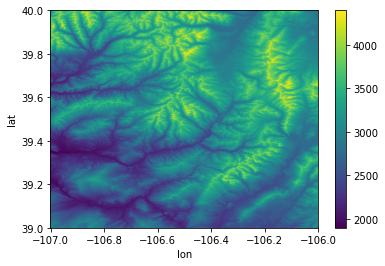

In [4]:
# retrieve all of the data at the native resolution into memory and plot
o = srtm.eval(srtm.native_coordinates)
o.plot()

## Reading SMAP h5 file
> PODPAC also wraps the `h5py` Python package <br>
> This can be used to read `h5` files, which was the storage format used for SMAP, as an example

This takes a little more work than reading the GeoTIFF because `h5` files are more flexible. So, we have to:
1. Find the 'keys' used for the data we want
2. Tell PODPAC what are the coordinates of the data

The example below is relatively streamlined, but each new dataset may require some iteration. For example, you'll have to consider the: 
* Order of the coordinates 
    * (lat, lon) vs (lon, lat)
* The dimension of the array
    * Is this a 2D array with lat-lon dimensions? 
    * Is this a 3D array with lat-lon-time dimensions? 

In [5]:
# Get the file path from the podpac_examples repostiory
filename = podpac_examples.get('raster/SMAP_L4_SM_aup_20181027T090000_Vv4030_001.h5')

# Set up the PODPAC node to read this file. Notice, we specify that the number -9999 should be interpreted as a 'nan' in Python.
smap = podpac.core.data.types.H5PY(source=filename, nan_vals=[-9999])

## 1. Find the keys we need

In [6]:
smap.keys

['/Analysis_Data/sm_profile_analysis',
 '/Analysis_Data/sm_profile_analysis_ensstd',
 '/Analysis_Data/sm_rootzone_analysis',
 '/Analysis_Data/sm_rootzone_analysis_ensstd',
 '/Analysis_Data/sm_surface_analysis',
 '/Analysis_Data/sm_surface_analysis_ensstd',
 '/Analysis_Data/soil_temp_layer1_analysis',
 '/Analysis_Data/soil_temp_layer1_analysis_ensstd',
 '/Analysis_Data/surface_temp_analysis',
 '/Analysis_Data/surface_temp_analysis_ensstd',
 '/EASE2_global_projection',
 '/Forecast_Data/sm_profile_forecast',
 '/Forecast_Data/sm_rootzone_forecast',
 '/Forecast_Data/sm_surface_forecast',
 '/Forecast_Data/soil_temp_layer1_forecast',
 '/Forecast_Data/surface_temp_forecast',
 '/Forecast_Data/tb_h_forecast',
 '/Forecast_Data/tb_h_forecast_ensstd',
 '/Forecast_Data/tb_v_forecast',
 '/Forecast_Data/tb_v_forecast_ensstd',
 '/Observations_Data/tb_h_obs',
 '/Observations_Data/tb_h_obs_assim',
 '/Observations_Data/tb_h_obs_errstd',
 '/Observations_Data/tb_h_obs_time_sec',
 '/Observations_Data/tb_h_or

This suggests that we want the `cell_lat` and `cell_lon` keys for coordinates. I also want to look at surface soil moisture, so let's consider the `/Analysis_Data/sm_surface_analysis` key for our data. 

Let's make a new class that tells PODPAC how to interpret the coordinates from the file.

In [7]:
class SMAPH5(podpac.core.data.types.H5PY):
    def get_native_coordinates(self):
        lat = self.dataset['cell_lat'][:, 0]
        lon = self.dataset['cell_lon'][0, :]
        # the order is important. lat = rows of array. lon = cols of array
        # return podpac.Coordinates([lon, lat], dims=['lon', 'lat'])  # <--- This is the WRONG order
        return podpac.Coordinates([lat, lon], dims=['lat', 'lon'])  

In [8]:
# Set up the PODPAC node to read this file
smap = SMAPH5(source=filename, nan_vals=[-9999], datakey='/Analysis_Data/sm_surface_analysis')
smap.native_coordinates # That looks correct

Coordinates
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.9533233642578, 179.9533233642578], N[3856], ctype['midpoint']

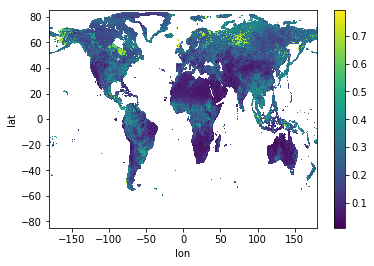

In [9]:
# retrieve all of the data at the native resolution into memory and plot
o = smap.eval(smap.native_coordinates)
o.plot()

# Example of automatic interpolation
Once the dataset is read through PODPAC, it can be re-interpolated automatically to a different coordinate system.

Let's read a subset of the SMAP data, using a bilinear interpolation at the resolution of the SRTM file. 

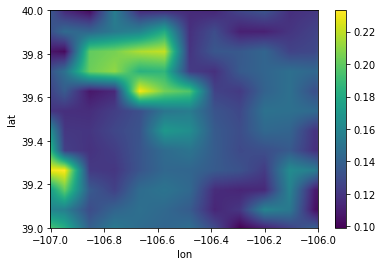

In [10]:
smap.interpolation = 'bilinear'
o = smap.eval(srtm.native_coordinates)
o.plot()